# Part A: Transfer Learning

In Part A, your task is to analyse the architectural difference between 3 CNN models and perform transfer learning on them to accurately predict 101 different classes from the Food101 Dataset.

You will have to perform transfer learning (using the weights obtained from the ImageNet dataset) on the following 3 pre-trained models and compare their results:

- GoogLeNet

- MobileNet V3

- Resnet

For each model, you will:

- Replace the Model Head: Remove the existing head (the final classification layers) and replace it with a new head consisting of three fully connected layers. The third fully connected layer will be the final prediction layer.

- Freeze Pre-Trained Layers: Keep all the pre-trained layers frozen so that only the new head is trained on the Food101 data.

# 1. Dataset Setup & Configuration

[1.1] Import all necessary libraries used for model training, data preprocessing, visualization, and evaluation.

In [1]:
# Importing all required libraries

# Core Python utilities
import os                    # File and directory operations
import tarfile               # Extract .tar.gz dataset files

# Data handling and visualization
import numpy as np           # Numerical operations
import matplotlib.pyplot as plt  # Plot training loss and accuracy
import seaborn as sns        # Confusion matrix heatmaps
from PIL import Image        # Open and transform image files

# PyTorch and TorchVision (deep learning tools)
import torch                 # Tensor operations and GPU support
import torch.nn as nn        # Neural network layers and loss functions
import torch.optim as optim  # Optimizers like Adam
import torchvision           # Used for visualization like torchvision.utils.make_grid()
from torch.utils.data import Dataset, DataLoader  # Dataset handling and batching
from torchvision import models, transforms        # Pretrained models and image transformations
from torchvision.models import mobilenet_v3_large # MobileNet V3 architecture (explicit import)

# Model evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Google Colab drive access
from google.colab import drive

[1.2] Mount Google Drive to access the dataset stored in your Drive from within the Colab environment.

In [2]:
# Mount Google Drive so that files from your Google Drive can be accessed within this Colab environment.
drive.mount('/content/drive')

Mounted at /content/drive


[1.3] Extract the Food-101 dataset from the .tar.gz archive stored in Google Drive to the local Colab environment.

In [3]:
# Define the path to the .tar.gz file stored in Google Drive
tar_path = '/content/drive/MyDrive/SharedDatasets/food-101.tar.gz'

# Define the target extraction directory (within Colab's virtual file system)
extract_path = '/content/food-101'

# Open and extract all contents of the tar.gz file into the target directory
with tarfile.open(tar_path, 'r:gz') as tar:
    tar.extractall(path=extract_path)

print("Extraction complete!")

Extraction complete!


[1.4] Explore the dataset structure and verify the number of training classes and image samples.

In [4]:
# Define the root folder where class image directories are stored
image_root = '/content/food-101/food-101/images'

# List and display the first 5 class folders (e.g., 'apple_pie', 'baklava', etc.)
print("Sample classes:", os.listdir(image_root)[:5])

# Open the train.txt file to count how many training image paths are listed
with open('/content/food-101/food-101/meta/train.txt', 'r') as f:
    train_list = f.readlines()

# Print the number of training samples referenced in the split
print("Training samples:", len(train_list))

Sample classes: ['poutine', 'sushi', 'mussels', 'gnocchi', 'miso_soup']
Training samples: 75750


[1.5] Check the available GPU type and memory status in the Colab environment.

In [5]:
# Check GPU type and memory stats (specific to Colab Pro/Premium)
!nvidia-smi

Fri Apr 25 01:46:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   33C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

[1.6] Verify if CUDA is available and print the name of the GPU being used by PyTorch.

In [6]:
# Check CUDA availability using PyTorch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("Running on CPU (GPU not available)")

CUDA available: True
GPU name: NVIDIA L4


[1.7] Define a custom PyTorch Dataset class to load and preprocess Food-101 images with optional transformations.

In [7]:
class Food101Dataset(Dataset):
    def __init__(self, txt_file, root_dir, transform=None):
        """
        Args:
            txt_file (str): Path to train.txt or test.txt containing relative image paths.
            root_dir (str): Path to the 'images' folder where class subfolders reside.
            transform (callable, optional): Optional image transformations to apply.
        """
        # Read image paths and append '.jpg' extension
        with open(txt_file, 'r') as file:
            self.image_paths = [line.strip() + '.jpg' for line in file]

        self.root_dir = root_dir
        self.transform = transform

        # Extract and sort class names from directory
        self.classes = sorted(os.listdir(root_dir))
        # Create mapping from class name to index
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

    def __len__(self):
        # Return total number of images in the dataset
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Get relative image path and construct full path
        rel_path = self.image_paths[idx]
        img_path = os.path.join(self.root_dir, rel_path)

        # Extract label from the class folder name
        label = self.class_to_idx[rel_path.split('/')[0]]

        # Load and convert image to RGB
        image = Image.open(img_path).convert("RGB")

        # Apply transforms if defined (e.g., Resize, Normalize)
        if self.transform:
            image = self.transform(image)

        return image, label

# 2. Dataset Preparation and Inspection

[2.1] Define image transformations, prepare the Food-101 training and test datasets, and load them using DataLoader for batch processing.

In [8]:
# Define data augmentation and normalization for the training set
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),         # Random crop and resize to 224x224
    transforms.RandomHorizontalFlip(),         # Randomly flip images for augmentation
    transforms.ToTensor(),                     # Convert PIL image to PyTorch Tensor
    transforms.Normalize(                      # Normalize using ImageNet means and stds
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Define resizing and normalization for the test set (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize(256),                    # Resize shorter side to 256
    transforms.CenterCrop(224),                # Crop center 224x224 region
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Set paths to image directory and split files
data_root = '/content/food-101/food-101'
images_dir = os.path.join(data_root, 'images')
train_txt = os.path.join(data_root, 'meta/train.txt')
test_txt = os.path.join(data_root, 'meta/test.txt')

# Create training and test datasets using the custom Food101Dataset class
train_dataset = Food101Dataset(train_txt, images_dir, transform=train_transform)
test_dataset = Food101Dataset(test_txt, images_dir, transform=test_transform)

# Load the datasets using DataLoader (with batching and parallel loading)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

[2.2] Fetch a batch of training images and visualize a sample grid to verify image loading and transformations.

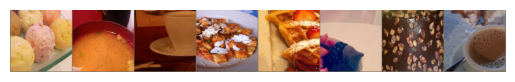

In [9]:
# Fetch one batch of images and labels from the train DataLoader
inputs, labels = next(iter(train_loader))

# Use torchvision utility to combine 8 images into a grid for display
out = torchvision.utils.make_grid(inputs[:8])

# Function to un-normalize and display the image grid
def imshow(inp):
    inp = inp.numpy().transpose((1, 2, 0))        # Convert from CHW to HWC format
    mean = [0.485, 0.456, 0.406]                  # Mean used in normalization
    std = [0.229, 0.224, 0.225]                   # Std used in normalization
    inp = std * inp + mean                        # Un-normalize the image
    inp = np.clip(inp, 0, 1)                      # Ensure pixel values are valid
    plt.imshow(inp)
    plt.axis('off')

# Call the imshow function to visualize the grid
imshow(out)

# 3. Model Setup and Training

[3.1] Define a training function that handles training, validation, logging, and model checkpointing.

In [10]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5):
    # Ensure model is on the correct device (GPU or CPU)
    model.to(device)
    best_acc = 0.0                   # To track best validation accuracy
    train_losses = []               # To store epoch-wise training loss
    val_accuracies = []             # To store epoch-wise validation accuracy

    for epoch in range(num_epochs):
        model.train()               # Set model to training mode
        running_loss = 0.0
        all_preds, all_labels = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()                   # Clear previous gradients
            outputs = model(inputs)                 # Forward pass
            loss = criterion(outputs, labels)       # Compute loss
            loss.backward()                         # Backpropagation
            optimizer.step()                        # Update weights

            # Accumulate training loss
            running_loss += loss.item() * inputs.size(0)

            # Track predictions and labels
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Compute average loss and training accuracy for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = accuracy_score(all_labels, all_preds)

        train_losses.append(epoch_loss)

        # Evaluation (Validation phase)
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_acc = accuracy_score(val_labels, val_preds)
        val_accuracies.append(val_acc)

        # Print performance summary for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}]  Train Loss: {epoch_loss:.4f}  "
              f"Train Acc: {epoch_acc:.4f}  Val Acc: {val_acc:.4f}")

        # Save model if validation accuracy improves
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_resnet50.pth')

    print(f"\nTraining complete. Best Val Acc: {best_acc:.4f}")
    return train_losses, val_accuracies

[3.2] Load the pretrained ResNet-50 model, freeze its feature extractor, and define a custom classifier head.

In [11]:
# Define computation device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the ResNet-50 model with pretrained ImageNet weights
resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Freeze all convolutional layers (i.e., pretrained base)
for param in resnet.parameters():
    param.requires_grad = False

# Replace the original fully connected head with a custom 3-layer head
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 512),  # First fully connected layer
    nn.ReLU(),                              # Activation
    nn.Dropout(0.3),                        # Regularization
    nn.Linear(512, 256),                    # Second fully connected layer
    nn.ReLU(),
    nn.Linear(256, 101)                     # Final output layer for 101 food classes
)

# Move the model to the selected device
resnet = resnet.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 201MB/s]


[3.3] Set up the loss function and optimizer to train only the newly added classifier head.

In [12]:
# Define the loss function for multi-class classification
criterion = nn.CrossEntropyLoss()

# Define the optimizer (only train the custom classifier head)
optimizer = torch.optim.Adam(resnet.fc.parameters(), lr=0.001)

[3.4] Train the frozen ResNet-50 model using the defined optimizer and track performance metrics across 5 epochs.

In [13]:
# Print a header to indicate the start of ResNet-50 training
# Useful for visually separating training logs when running multiple models
print("🔄 Training ResNet-50 (Frozen) for 5 epochs...")

# Call the training function for ResNet-50
# - Uses the frozen model
# - Applies Adam optimizer on the classifier head only
# - Records loss and accuracy metrics for each epoch
train_losses_resnet, val_accuracies_resnet = train_model(
    resnet,                      # The ResNet-50 model
    train_loader,                # Training data loader
    test_loader,                 # Validation/test data loader
    criterion,                   # Loss function: CrossEntropyLoss
    optimizer,                   # Optimizer: Adam on resnet.fc
    num_epochs=5                 # Number of epochs to train
)

🔄 Training ResNet-50 (Frozen) for 5 epochs...
Epoch [1/5]  Train Loss: 2.8340  Train Acc: 0.3219  Val Acc: 0.5490
Epoch [2/5]  Train Loss: 2.2752  Train Acc: 0.4365  Val Acc: 0.5922
Epoch [3/5]  Train Loss: 2.1373  Train Acc: 0.4689  Val Acc: 0.6183
Epoch [4/5]  Train Loss: 2.0654  Train Acc: 0.4832  Val Acc: 0.6296
Epoch [5/5]  Train Loss: 2.0141  Train Acc: 0.4971  Val Acc: 0.6391

Training complete. Best Val Acc: 0.6391


[3.5] Plot training loss and validation accuracy across epochs to visualize ResNet-50 performance trends.

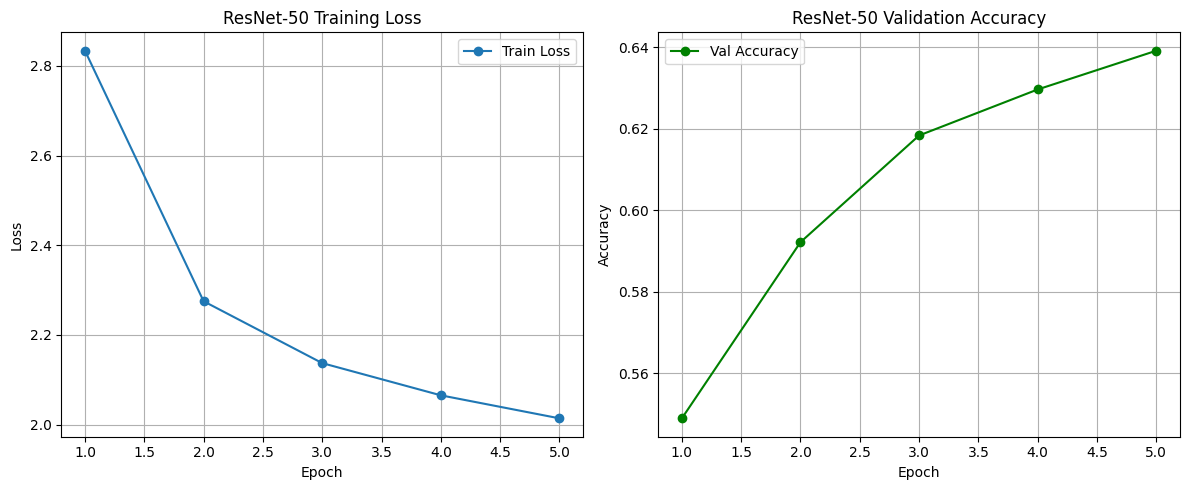

In [14]:
# Plot training loss and validation accuracy for ResNet-50 (Properly synced and labeled)

# Generate epoch numbers starting from 1 (matches training logs: Epoch [1/5] ... [5/5])
epochs = list(range(1, len(train_losses_resnet) + 1))

plt.figure(figsize=(12, 5))  # Create a wide figure with two side-by-side plots

# Plot Training Loss per Epoch
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_resnet, label='Train Loss', marker='o')
plt.title("ResNet-50 Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Plot Validation Accuracy per Epoch
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies_resnet, label='Val Accuracy', marker='o', color='green')
plt.title("ResNet-50 Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# Adjust layout and render both plots
plt.tight_layout()
plt.show()

[3.6] Evaluate the ResNet-50 model using a classification report and confusion matrix to assess class-wise performance.

Classification Report for ResNet-50:
                         precision    recall  f1-score   support

              apple_pie       0.42      0.29      0.34       250
         baby_back_ribs       0.73      0.52      0.61       250
                baklava       0.61      0.73      0.67       250
         beef_carpaccio       0.74      0.67      0.70       250
           beef_tartare       0.60      0.50      0.54       250
             beet_salad       0.70      0.41      0.52       250
               beignets       0.78      0.81      0.79       250
               bibimbap       0.60      0.87      0.71       250
          bread_pudding       0.38      0.30      0.34       250
      breakfast_burrito       0.68      0.43      0.52       250
             bruschetta       0.68      0.40      0.50       250
           caesar_salad       0.69      0.73      0.71       250
                cannoli       0.62      0.78      0.69       250
          caprese_salad       0.55      0.68      0.

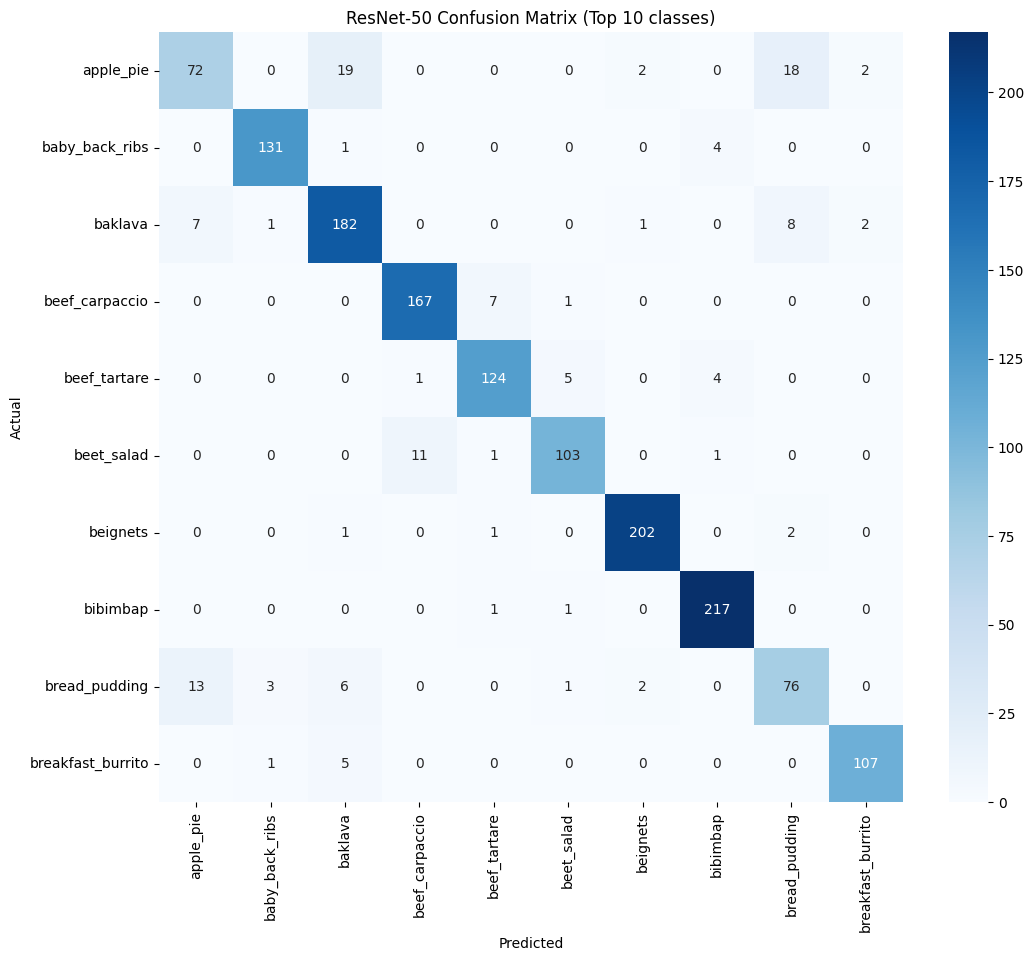

In [15]:
# Set model to evaluation mode (disable dropout/batchnorm updates)
model = resnet
model.eval()

all_preds, all_labels = [], []

# Generate predictions on the test set
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Get predicted class indices
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report with precision, recall, and F1-score for each class
print("Classification Report for ResNet-50:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix (limited to first 10 classes for readability)
plt.figure(figsize=(12, 10))
sns.heatmap(cm[:10, :10], annot=True, fmt="d", cmap="Blues",
            xticklabels=test_dataset.classes[:10],
            yticklabels=test_dataset.classes[:10])
plt.title("ResNet-50 Confusion Matrix (Top 10 classes)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

[3.7] Load the GoogLeNet model, freeze pretrained layers, and define a custom 3-layer classifier head.

In [16]:
# Load GoogLeNet architecture with pretrained ImageNet weights
# GoogLeNet (Inception v1) uses inception modules for efficient feature extraction
googlenet = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)

# Freeze all convolutional layers so only the custom classifier is trained
# This allows GoogLeNet to act as a fixed feature extractor
for param in googlenet.parameters():
    param.requires_grad = False

# Replace the original final classification layer (googlenet.fc)
# New classifier has 3 fully connected (FC) layers with ReLU and dropout for regularization
googlenet.fc = nn.Sequential(
    nn.Linear(googlenet.fc.in_features, 512),  # First FC layer
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),                       # Second FC layer
    nn.ReLU(),
    nn.Linear(256, 101)                        # Output layer: one logit per food class
)

# Move the model to the correct device (GPU if available)
googlenet = googlenet.to(device)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 228MB/s]


[3.8] Set up the loss function and optimizer to train only the custom classifier head of GoogLeNet.

In [17]:
# Define the loss function for GoogLeNet
# CrossEntropyLoss is appropriate for multi-class classification tasks
criterion = nn.CrossEntropyLoss()

# Define the optimizer
# Only parameters in googlenet.fc (custom classifier head) are trainable
# This keeps the pretrained layers frozen
optimizer = torch.optim.Adam(googlenet.fc.parameters(), lr=0.001)

[3.9] Train the frozen GoogLeNet model for 5 epochs and log training/validation performance.

In [18]:
# Print a header to separate GoogLeNet training output from other models
print("🔄 Training GoogLeNet (Frozen) for 5 epochs...")

# Train GoogLeNet using the shared train_model function
# - Uses CrossEntropyLoss
# - Updates only the parameters in the custom FC head
train_losses_googlenet, val_accuracies_googlenet = train_model(
    googlenet,                    # GoogLeNet model with frozen base
    train_loader,                 # Training DataLoader
    test_loader,                  # Validation DataLoader
    criterion,                    # CrossEntropyLoss
    optimizer,                    # Adam optimizer on googlenet.fc
    num_epochs=5                  # Fixed number of training epochs
)

🔄 Training GoogLeNet (Frozen) for 5 epochs...
Epoch [1/5]  Train Loss: 3.4436  Train Acc: 0.1909  Val Acc: 0.4030
Epoch [2/5]  Train Loss: 2.9718  Train Acc: 0.2856  Val Acc: 0.4436
Epoch [3/5]  Train Loss: 2.8661  Train Acc: 0.3091  Val Acc: 0.4632
Epoch [4/5]  Train Loss: 2.8188  Train Acc: 0.3210  Val Acc: 0.4816
Epoch [5/5]  Train Loss: 2.7894  Train Acc: 0.3264  Val Acc: 0.4830

Training complete. Best Val Acc: 0.4830


[3.10] Plot GoogLeNet's training loss and validation accuracy across epochs to visualize performance trends.

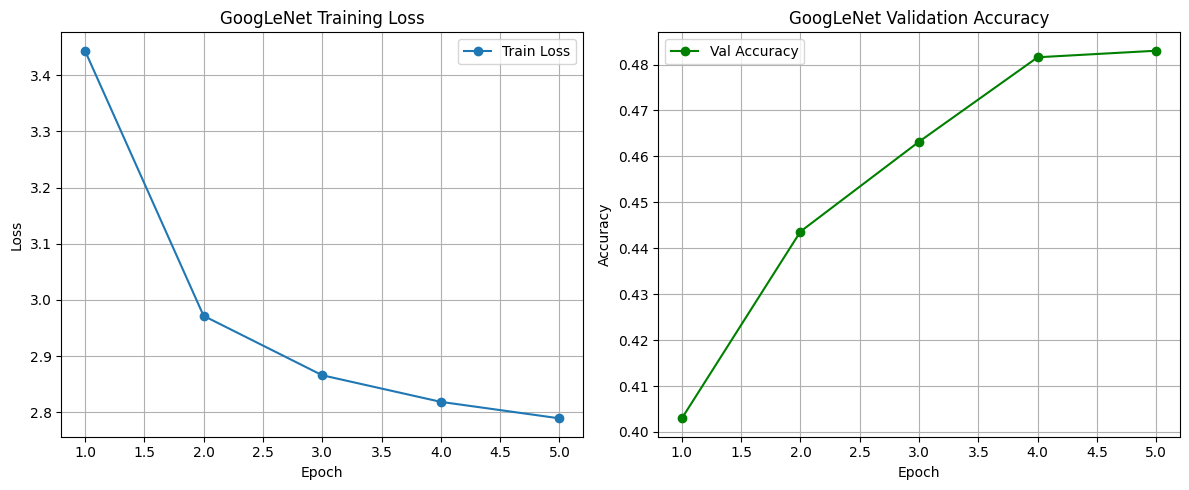

In [19]:
# Plot training performance metrics for GoogLeNet

# Generate epoch numbers starting from 1 (matches training logs: Epoch [1/5] ... [5/5])
epochs = list(range(1, len(train_losses_googlenet) + 1))

plt.figure(figsize=(12, 5))  # Create a wide figure with two side-by-side plots

# Plot 1: Training Loss per Epoch
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_googlenet, label='Train Loss', marker='o')
plt.title("GoogLeNet Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Plot 2: Validation Accuracy per Epoch
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies_googlenet, label='Val Accuracy', marker='o', color='green')
plt.title("GoogLeNet Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# Adjust layout and render both plots
plt.tight_layout()
plt.show()

[3.11] Evaluate the GoogLeNet model using classification metrics and a confusion matrix for the top 10 classes.

Classification Report for GoogLeNet:
                         precision    recall  f1-score   support

              apple_pie       0.33      0.08      0.13       250
         baby_back_ribs       0.47      0.38      0.42       250
                baklava       0.63      0.45      0.52       250
         beef_carpaccio       0.64      0.32      0.43       250
           beef_tartare       0.44      0.10      0.17       250
             beet_salad       0.24      0.41      0.31       250
               beignets       0.68      0.75      0.72       250
               bibimbap       0.54      0.70      0.61       250
          bread_pudding       0.21      0.29      0.24       250
      breakfast_burrito       0.53      0.28      0.37       250
             bruschetta       0.31      0.24      0.27       250
           caesar_salad       0.34      0.51      0.41       250
                cannoli       0.42      0.61      0.50       250
          caprese_salad       0.39      0.36      0.

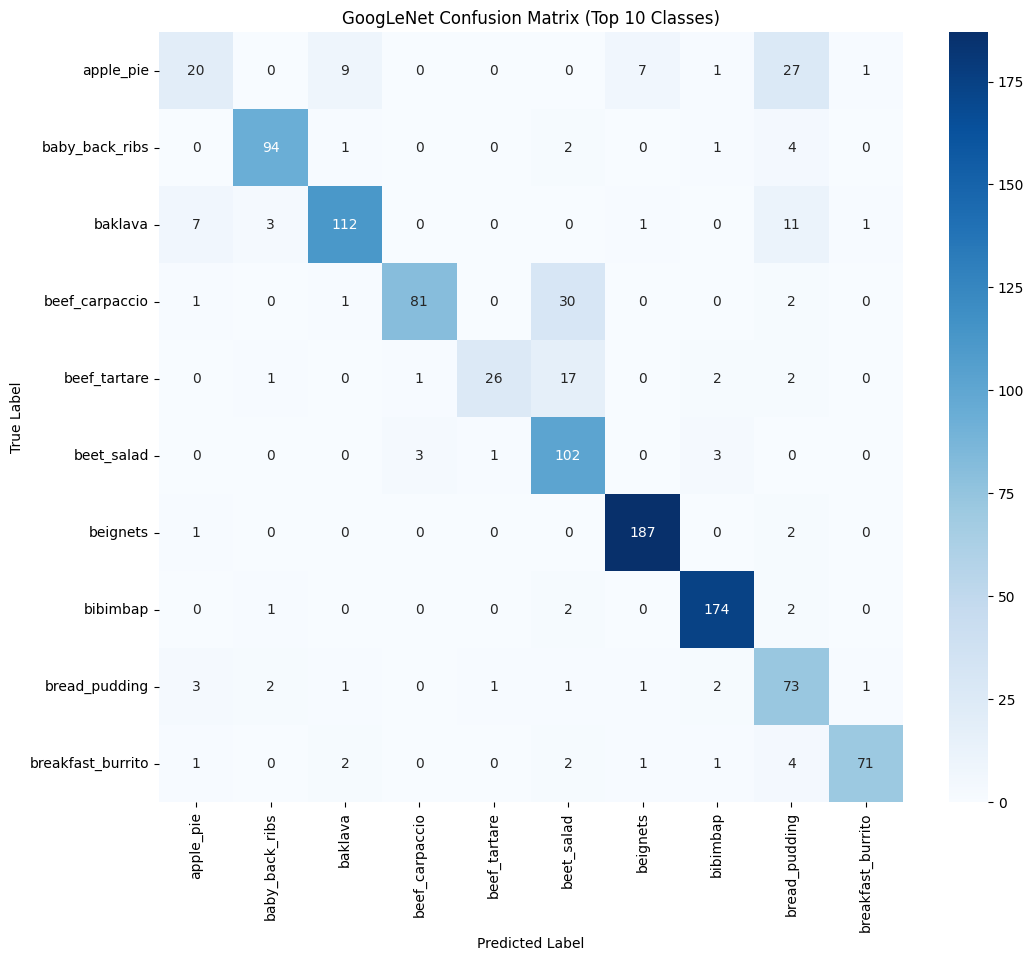

In [20]:
# Set the GoogLeNet model to evaluation mode
# This disables dropout and batchnorm updates for consistent inference
model = googlenet
model.eval()

# Initialize lists to collect all predictions and true labels
all_preds = []
all_labels = []

# Perform inference on the test set
with torch.no_grad():  # Disable gradient tracking for efficiency
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass through the model
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Get predicted class index

        # Append results to tracking lists
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report including precision, recall, and F1-score
print("Classification Report for GoogLeNet:")
print(classification_report(
    all_labels, all_preds,
    target_names=test_dataset.classes
))

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix for the first 10 classes (to avoid overcrowding)
plt.figure(figsize=(12, 10))
sns.heatmap(cm[:10, :10], annot=True, fmt="d", cmap="Blues",
            xticklabels=test_dataset.classes[:10],
            yticklabels=test_dataset.classes[:10])
plt.title("GoogLeNet Confusion Matrix (Top 10 Classes)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

[3.12] Load MobileNet V3, freeze its pretrained layers, and define a custom classifier head for Food-101 classification.

In [21]:
# Load MobileNet V3 model pretrained on ImageNet
# This version is 'large' and optimized for mobile and low-power devices
mobilenet = mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)

# Freeze all layers in the pretrained feature extractor
# This ensures only the new classifier head is trained
for param in mobilenet.parameters():
    param.requires_grad = False

# Replace the default classifier head (already a Sequential block)
# We replace it with a deeper 3-layer structure for better learning capacity
mobilenet.classifier = nn.Sequential(
    nn.Linear(mobilenet.classifier[0].in_features, 512),  # First fully connected layer
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),                                 # Second FC layer
    nn.ReLU(),
    nn.Linear(256, 101)                                  # Output layer (101 classes in Food101)
)

# Move the model to the appropriate device (GPU/CPU)
mobilenet = mobilenet.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 225MB/s]


[3.13] Define the loss function and optimizer to train only the custom classifier of MobileNet V3.

In [22]:
# Define the loss function for MobileNet V3
# CrossEntropyLoss is standard for multi-class classification (101 food classes)
criterion = nn.CrossEntropyLoss()

# Define the optimizer to train only the custom classifier layers
# All other layers are frozen, so we exclude them from optimization
optimizer = torch.optim.Adam(mobilenet.classifier.parameters(), lr=0.001)

[3.14] Train the frozen MobileNet V3 model for 5 epochs and log training and validation metrics.

In [23]:
# Print log header to clearly indicate which model is being trained
print("🔄 Training MobileNet V3 (Frozen) for 5 epochs...")

# Train the MobileNet V3 model using the train_model function
# - Feature extractor is frozen
# - Only classifier head is trained
train_losses_mobilenet, val_accuracies_mobilenet = train_model(
    mobilenet,                 # MobileNet V3 model
    train_loader,              # Training DataLoader
    test_loader,               # Validation DataLoader
    criterion,                 # CrossEntropyLoss
    optimizer,                 # Adam optimizer on mobilenet.classifier
    num_epochs=5               # Fixed number of training epochs
)

🔄 Training MobileNet V3 (Frozen) for 5 epochs...
Epoch [1/5]  Train Loss: 2.8480  Train Acc: 0.3165  Val Acc: 0.5329
Epoch [2/5]  Train Loss: 2.3412  Train Acc: 0.4209  Val Acc: 0.5732
Epoch [3/5]  Train Loss: 2.2262  Train Acc: 0.4484  Val Acc: 0.5924
Epoch [4/5]  Train Loss: 2.1554  Train Acc: 0.4648  Val Acc: 0.6064
Epoch [5/5]  Train Loss: 2.1124  Train Acc: 0.4737  Val Acc: 0.6189

Training complete. Best Val Acc: 0.6189


[3.15] Plot MobileNet V3's training loss and validation accuracy across epochs to assess learning behavior.

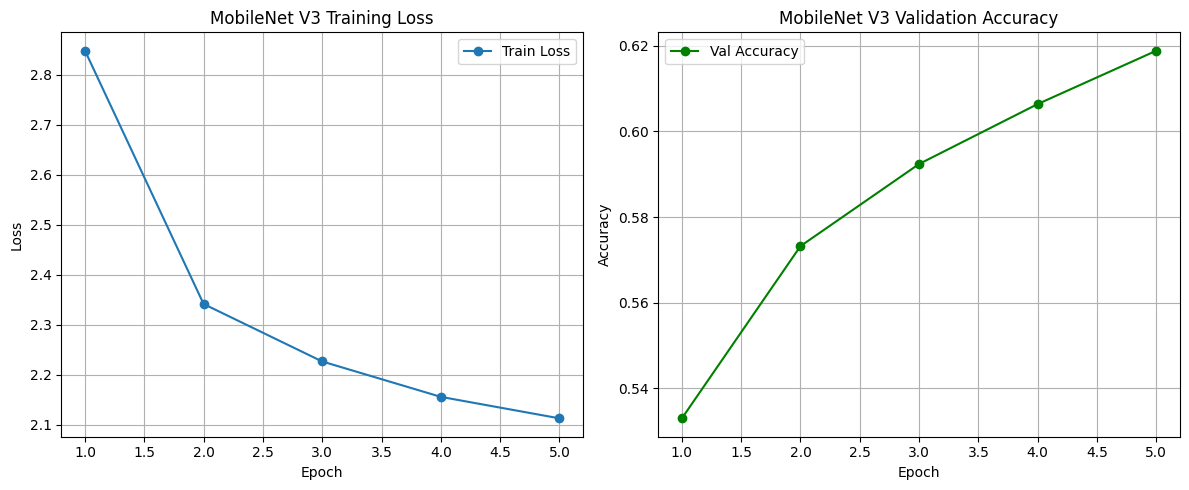

In [24]:
# Plot training performance metrics for MobileNet V3

# Generate epoch numbers starting from 1 (matches training logs: Epoch [1/5] ... [5/5])
epochs = list(range(1, len(train_losses_mobilenet) + 1))

plt.figure(figsize=(12, 5))  # Create a wide figure with two side-by-side plots

# Plot 1: Training Loss over Epochs
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_mobilenet, label='Train Loss', marker='o')
plt.title("MobileNet V3 Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Plot 2: Validation Accuracy over Epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies_mobilenet, label='Val Accuracy', marker='o', color='green')
plt.title("MobileNet V3 Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# Apply tight layout for clean subplot arrangement
plt.tight_layout()
plt.show()

[3.16] Evaluate MobileNet V3 on the test set using a classification report and confusion matrix for the top 10 classes.

Classification Report for MobileNet V3:
                         precision    recall  f1-score   support

              apple_pie       0.32      0.24      0.28       250
         baby_back_ribs       0.55      0.59      0.57       250
                baklava       0.66      0.72      0.69       250
         beef_carpaccio       0.50      0.70      0.58       250
           beef_tartare       0.46      0.54      0.50       250
             beet_salad       0.64      0.40      0.49       250
               beignets       0.79      0.74      0.76       250
               bibimbap       0.80      0.80      0.80       250
          bread_pudding       0.61      0.25      0.35       250
      breakfast_burrito       0.52      0.46      0.49       250
             bruschetta       0.57      0.39      0.46       250
           caesar_salad       0.64      0.70      0.67       250
                cannoli       0.56      0.71      0.63       250
          caprese_salad       0.46      0.72     

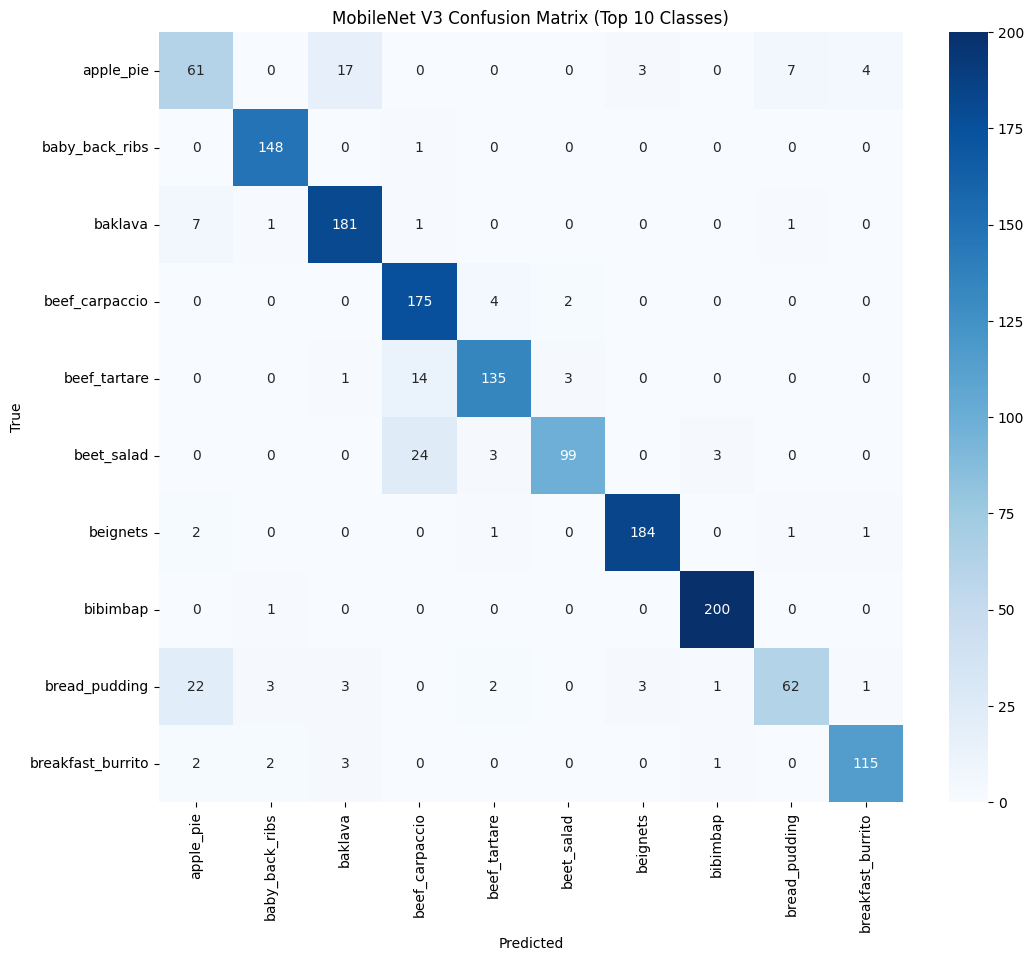

In [25]:
# Set MobileNet to evaluation mode (ensures consistent inference)
model = mobilenet
model.eval()

# Initialize storage for predictions and ground truth labels
all_preds = []
all_labels = []

# Run inference on the test set
with torch.no_grad():  # Disable gradient tracking for efficiency
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Get index of highest logit per input

        # Collect predictions and true labels (convert to CPU for sklearn)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report (includes precision, recall, and F1-score per class)
print("Classification Report for MobileNet V3:")
print(classification_report(
    all_labels, all_preds,
    target_names=test_dataset.classes
))

# Generate confusion matrix to evaluate class-level prediction alignment
cm = confusion_matrix(all_labels, all_preds)

# Visualize confusion matrix (limited to first 10 classes for clarity)
plt.figure(figsize=(12, 10))
sns.heatmap(cm[:10, :10], annot=True, fmt='d', cmap='Blues',
            xticklabels=test_dataset.classes[:10],
            yticklabels=test_dataset.classes[:10])
plt.title("MobileNet V3 Confusion Matrix (Top 10 Classes)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 4. Model Comparison and Summary

[4.1] Performance Overview

| Model         | Final Val Accuracy | Best Val Accuracy | Comments                        |
|---------------|--------------------|-------------------|---------------------------------|
| **ResNet-50** | 0.6391             | **Highest**     | Strongest across all metrics    |
| MobileNet V3  | 0.6189             | High              | Lightweight, strong performance |
| GoogLeNet     | 0.4830             | Lower             | Underperformed comparatively    |

---

[4.2] Training Curves

- **ResNet-50** showed a clear downward loss trend and upward validation accuracy. It was stable and had no signs of overfitting across 5 epochs.
- **MobileNet V3** also had smooth convergence and generalization. Its performance was impressive for a compact model.
- **GoogLeNet**, while converging slowly, plateaued in validation accuracy early — suggesting it may benefit from longer training or fine-tuning.

---

[4.3] Classification Report Highlights

- **ResNet-50** achieved strong F1-scores across a wide range of classes. It handled complex categories well.
- **MobileNet V3** had competitive precision and recall, especially for classes like `clam_chowder`, `miso_soup`, and `dumplings`.
- **GoogLeNet** had noticeably lower F1-scores for difficult classes like `ceviche`, `tiramisu`, and `filet_mignon`.

---

[4.4] Confusion Matrix Insights

- **ResNet-50**’s matrix showed high correct predictions with fewer off-diagonal errors in top 10 classes.
- **MobileNet V3** had slightly more confusion but remained strong for classes like `beignets`, `baklava`, and `bibimbap`.
- **GoogLeNet** exhibited more confusion between similar categories, highlighting limitations of its older architecture.

---

[4.5] Conclusion

ResNet-50 was the most robust model overall, balancing strong accuracy and consistency across all classes.  
MobileNet V3 offers an excellent trade-off between performance and computational efficiency.  
GoogLeNet, while historically impactful, underperformed in this task and would likely need more tuning or epochs to catch up.